In [304]:
!pip install seaborn -U

You should consider upgrading via the '/Users/ruslansuckov/PycharmProjects/pythonProject1/venv/bin/python -m pip install --upgrade pip' command.


In [305]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error)
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, MetricVisualizer
from sklearn.model_selection import train_test_split

Загрузим данные из CSV. Сразу трансформируем даты\время.

In [306]:
df_arc = pd.read_csv("datasets/final_steel/data_arc.csv", parse_dates=[1, 2], index_col='key')
df_bulk = pd.read_csv("datasets/final_steel/data_bulk.csv", index_col='key')
df_bulk_time = pd.read_csv("datasets/final_steel/data_bulk_time.csv", parse_dates=list(range(1, 16)), index_col='key')
df_gas = pd.read_csv("datasets/final_steel/data_gas.csv", index_col='key')
df_temp = pd.read_csv("datasets/final_steel/data_temp.csv", parse_dates=[1], index_col='key')
df_wire = pd.read_csv("datasets/final_steel/data_wire.csv", index_col='key')
df_wire_time = pd.read_csv("datasets/final_steel/data_wire_time.csv", parse_dates=list(range(1, 10)), index_col='key')

Приведем наименования столбцов к одному формату

In [307]:
df_arc.columns = ['start_heat', 'end_heat', 'active_power', 'reactive_power']
df_bulk.columns = df_bulk.columns.str.lower().str.replace(" ", "_")
df_bulk_time.columns = df_bulk_time.columns.str.lower().str.replace(" ", "_")
df_gas.columns = ['gas_1']
df_temp.columns = ['sample_time', 'temp']
df_wire.columns = df_wire.columns.str.lower().str.replace(" ", "_")
df_wire_time.columns = df_wire_time.columns.str.lower().str.replace(" ", "_")

In [308]:
def box_plot_stats(df: pd.DataFrame):
    plt.figure(figsize=(16, 8))
    graph = sns.boxplot(data=df)
    return graph

<AxesSubplot: >

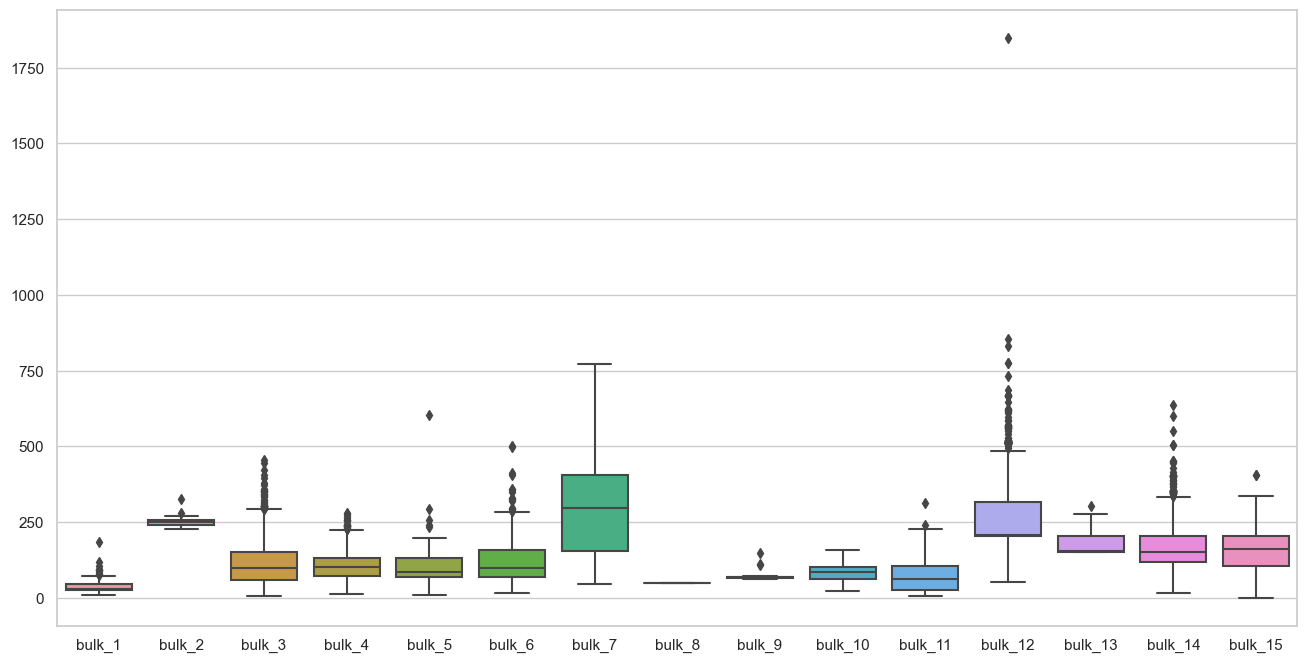

In [309]:
box_plot_stats(df_bulk)

8 и 9 набор добавок используется редко. Интересен большой вброс 12 добавки в один из замеров.

<AxesSubplot: >

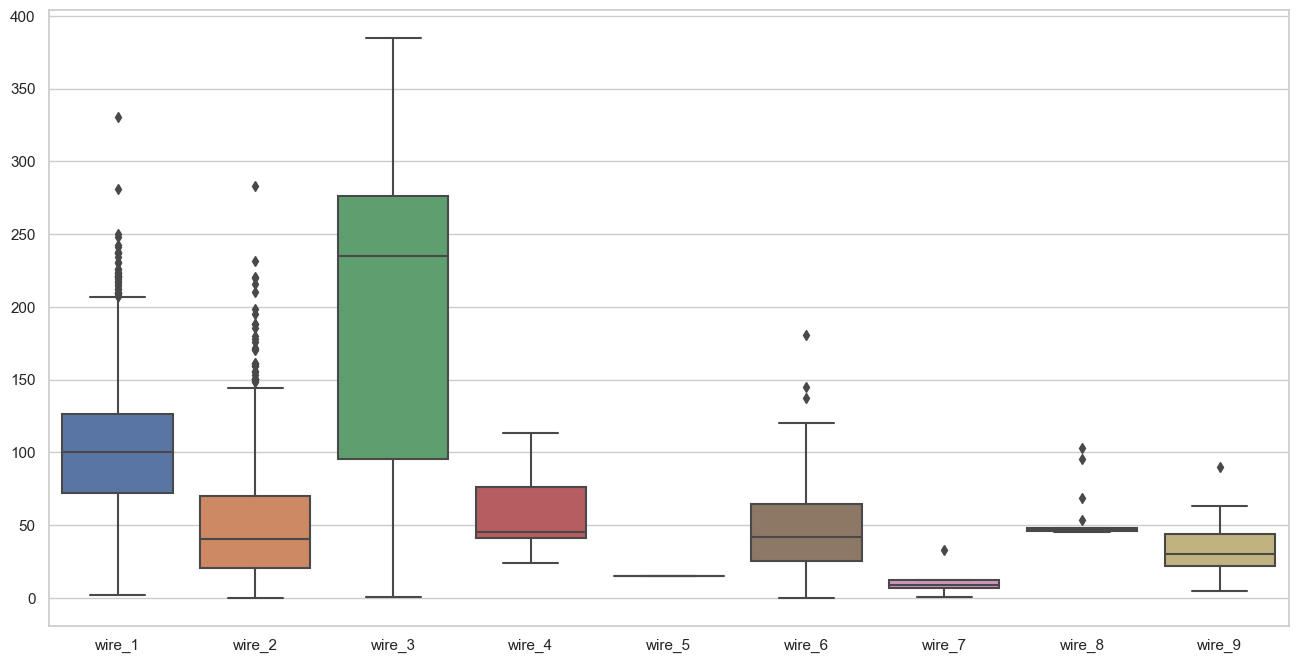

In [310]:
box_plot_stats(df_wire)

5 и 8 набор проводов тоже слабо представлены.

<AxesSubplot: >

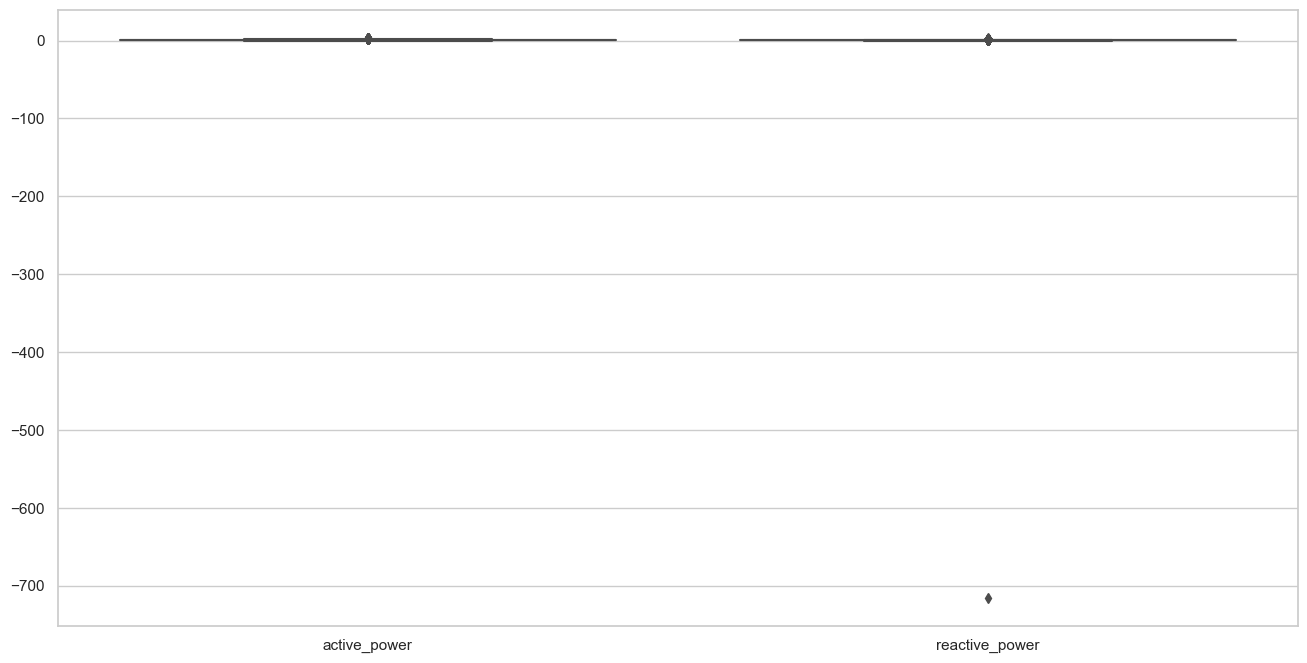

In [311]:
box_plot_stats(df_arc)

Выброс в reactive

In [313]:
df_arc = df_arc.query('reactive_power > 0')

<AxesSubplot: >

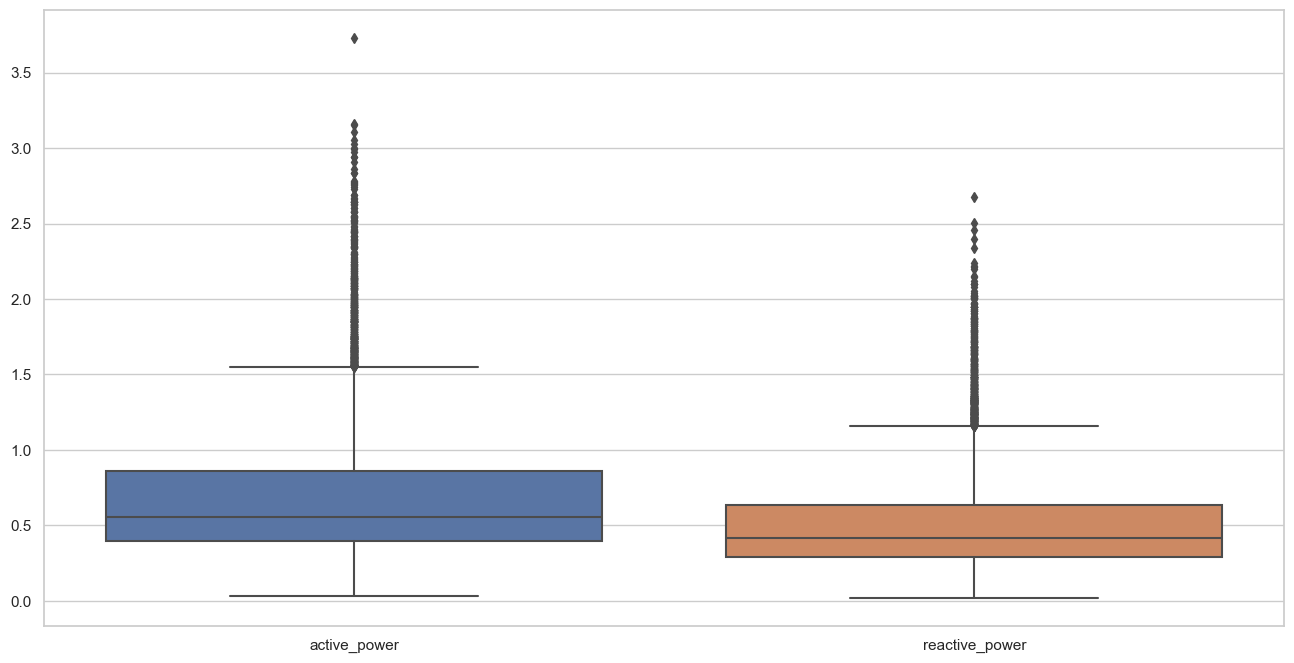

In [314]:
box_plot_stats(df_arc)

<AxesSubplot: >

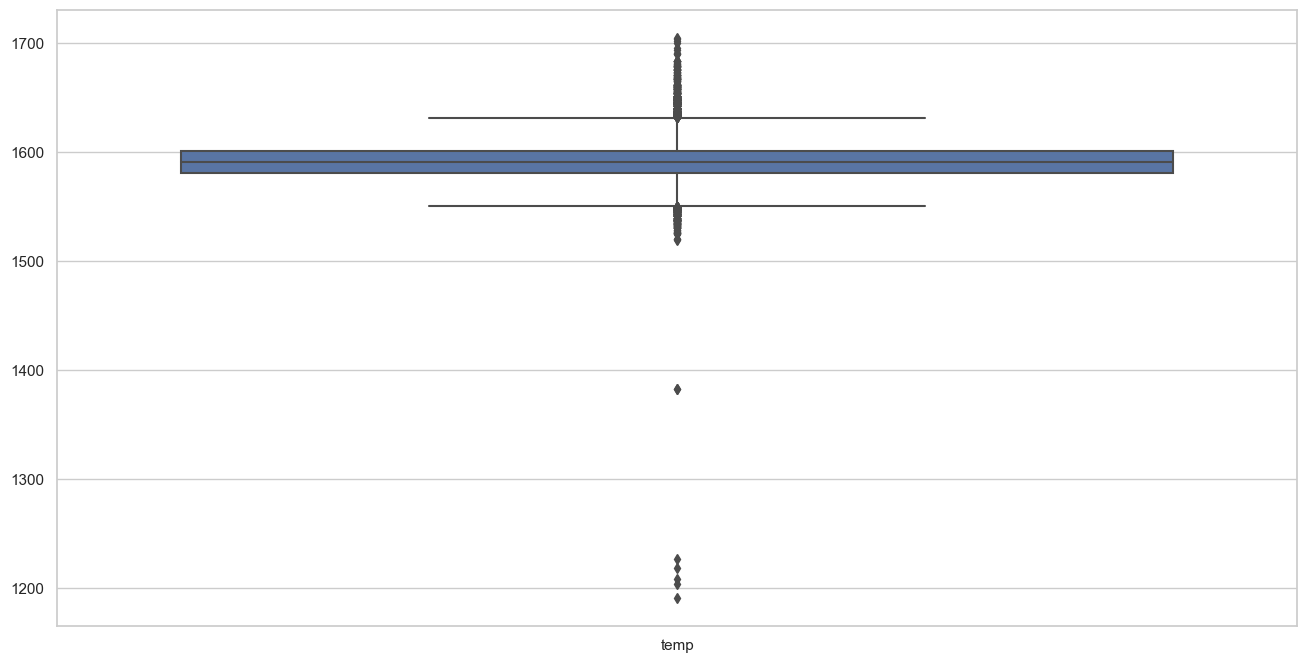

In [316]:
box_plot_stats(df_temp)

Температуры в основном лежат между 1650 и 1550. Есть несколько сильно низких значений в районе 1200. Также очистим таблицу температур от нулей.

In [317]:
df_temp = df_temp.dropna()

In [318]:
df_temp

,sample_time,temp
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0
...,...,...
3237,2019-08-31 22:44:04,1569.0
3238,2019-08-31 23:30:31,1584.0
3239,2019-09-01 01:31:47,1598.0


Поскольку нам необходимо узнать последний температуру - сгруппируем их, и очистим от значений где был только один замер или температуры не изменилась.

In [319]:
df_window = df_temp.groupby(df_temp.index).agg({'sample_time': [np.min, np.max]})
df_window.columns = ['first', 'last']
df_window = df_window.query("first != last")

Добавим сами температуры.

In [320]:
df_window_temp = (
    df_window
    .reset_index()
    .merge(df_temp.reset_index(), left_on=['first', 'key'], right_on=['sample_time', 'key'])
    .drop('sample_time', axis=1)
    .rename({'temp': 'first_temp'}, axis=1)
)
df_window_temp = (
    df_window_temp
    .merge(df_temp.reset_index(), left_on=['last', 'key'], right_on=['sample_time', 'key'])
    .drop('sample_time', axis=1)
    .rename({'temp': 'last_temp'}, axis=1)
)
df_window_temp = df_window_temp.query("first_temp != last_temp")

Нас интересуют подачи энергии между замерами температур.

In [321]:
df_arc_window = (
    df_arc
    .reset_index()
    .merge(df_window_temp, left_on=['key'], right_on=['key']).drop(['first_temp', 'last_temp'], axis=1)
)

In [322]:
def is_in_data_range(row: list):
    columns = [x for x in row.index if x not in ['first', 'last']]
    first = row['first']
    last = row['last']
    for col in columns:
        if row[col] is pd.NaT:
            continue
        if row[col] < first or row[col] > last:
            return False
    return True

Иногда происходит подогрев сплава до снятия первого показателя.

In [323]:
df_arc_window['filter'] = df_arc_window.select_dtypes(include=['datetime64']).apply(is_in_data_range, axis=1)
df_arc_window = df_arc_window.query("filter == True")
df_arc_window = df_arc_window.drop(['start_heat', 'end_heat', 'filter'], axis=1)

In [324]:
df_arc_window.head()

,key,active_power,reactive_power,first,last
3,1,1.659363,1.062669,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,0.692755,0.414397,2019-05-03 11:16:18,2019-05-03 11:30:39
6,2,1.296415,0.892914,2019-05-03 11:37:27,2019-05-03 11:59:12
7,2,0.490377,0.305281,2019-05-03 11:37:27,2019-05-03 11:59:12
8,2,0.827743,0.516874,2019-05-03 11:37:27,2019-05-03 11:59:12


Сгрупируем и добавим выделенную энергию к таблице температур.

In [258]:
df_window_temp = (
    df_window_temp
    .merge(df_arc_window.groupby('key')
           .agg({'active_power': sum, 'reactive_power': sum}),
           on='key', how='left')
)

Проведем похожие операции для добавок и проводов. Так же есть записи когда замер температуры выполнялся уже после добавление добавок. Мы не можем использовать таких для предсказаний.

In [327]:
df_bulk_time['max'] = df_bulk_time.max(axis=1, numeric_only=False)
df_bulk_time['min'] = df_bulk_time.min(axis=1, numeric_only=False)
df_bulk_time = df_bulk_time.reset_index()

df_bulk_time_window = (
    df_bulk_time
    .merge(df_window_temp, left_on=['key'], right_on=['key']).drop(
        ['first_temp', 'last_temp'], axis=1)
)
df_bulk_time_window['filter'] = df_bulk_time_window[['first', 'last', 'max', 'min']].apply(is_in_data_range, axis=1)
df_bulk_time_window = df_bulk_time_window.query("filter == True")
df_bulk_time_window = df_bulk_time_window.drop(['filter'], axis=1)

In [328]:
df_wire_time['max'] = df_wire_time.max(axis=1, numeric_only=False)
df_wire_time['min'] = df_wire_time.min(axis=1, numeric_only=False)
df_wire_time = df_wire_time.reset_index()

df_wire_time_window = (
    df_wire_time
    .merge(df_window_temp, left_on=['key'], right_on=['key'])
    .drop(['first_temp', 'last_temp'], axis=1))
df_wire_time_window['filter'] = df_wire_time_window[['first', 'last', 'max', 'min']].apply(is_in_data_range, axis=1)

In [329]:
df_wire_time_window.query("filter == False").shape

(197, 15)

Еще 200, где провода добавляли до первого сбора показателей. Возможно стоит уточнить причины такого, т.к. это выглядит как нарушения этапов производства.

In [330]:
df_wire_time_window = df_wire_time_window.query("filter == True")
df_wire_time_window = df_wire_time_window.drop(['filter'], axis=1)

Отфильтруем данные, оставив только когда добавки были выполнены между снятиями температур и мы знаем о том, что текущие металлы без дополнительных примесей. Так же добавим данные о газе.

In [331]:
df_keys = df_window_temp.merge(df_wire_time_window['key'], on=['key'])
df_keys = df_keys.merge(df_wire.reset_index(), on=['key'])
df_keys = df_keys.merge(df_bulk_time_window['key'], on=['key'])
df_keys = df_keys.merge(df_bulk.reset_index(), on=['key'])
df_keys = df_keys.merge(df_gas.reset_index(), how='left', on=['key'])
df_keys = df_keys.set_index('key')
df_keys = df_keys.fillna(0)

Удалим пятый провод, он статичен.

In [332]:
df_keys = df_keys.drop(['wire_5', 'first', 'last'], axis=1)

Рассмотрим таблицу корреляций. И почистим от сильно коррелирующих столбцов.

In [333]:
corr = df_keys.corr()
corr_power = 0.8

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= corr_power:
            if columns[j]:
                columns[j] = False
selected_columns = df_keys.columns[columns]
df_keys = df_keys[selected_columns]

In [334]:
list_of_final = [col for col in df_keys.columns if 'last_temp' not in col]

In [337]:
df_keys.corr()

,first_temp,last_temp,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,...,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
first_temp,1.000000,0.237677,0.204216,-0.078215,0.004910,0.056281,0.047464,0.044536,-0.019120,-0.002542,...,-0.102933,0.073751,-0.011934,0.045965,-0.104971,-0.045879,0.011356,-0.117269,-0.020721,0.039891
last_temp,0.237677,1.000000,0.311682,-0.181443,-0.055095,-0.179467,-0.115938,-0.150668,-0.017728,-0.035978,...,-0.170981,-0.118366,-0.029351,0.056312,-0.105883,0.259883,-0.022391,0.137524,0.269862,0.053133
wire_1,0.204216,0.311682,1.000000,-0.055877,0.033687,-0.150117,-0.168818,-0.074302,0.027224,0.017783,...,-0.257774,-0.157630,0.036392,0.064906,-0.113344,0.187752,0.042565,-0.051108,0.141694,0.101580
wire_2,-0.078215,-0.181443,-0.055877,1.000000,0.090891,-0.035377,-0.058623,-0.017615,0.036672,0.241359,...,0.175588,-0.001017,0.021510,-0.102784,0.075923,-0.080295,-0.015488,0.040047,-0.084064,0.107825
wire_3,0.004910,-0.055095,0.033687,0.090891,1.000000,0.182852,0.188497,0.113500,-0.006652,-0.011422,...,-0.046136,0.177555,-0.002636,-0.026799,-0.021645,-0.129184,-0.009183,-0.019105,-0.123705,0.105090
wire_4,0.056281,-0.179467,-0.150117,-0.035377,0.182852,1.000000,0.549759,0.609232,-0.004025,-0.006910,...,-0.027949,0.749224,-0.001595,-0.016214,-0.013096,-0.086585,-0.005556,-0.124392,-0.093926,0.143932
wire_6,0.047464,-0.115938,-0.168818,-0.058623,0.188497,0.549759,1.000000,0.386688,-0.006717,-0.011533,...,-0.041074,0.583924,-0.002662,-0.027060,-0.002150,-0.054517,-0.009273,-0.072746,-0.044221,0.130528
wire_7,0.044536,-0.150668,-0.074302,-0.017615,0.113500,0.609232,0.386688,1.000000,-0.002004,-0.003441,...,-0.013916,0.372487,-0.000794,-0.008073,-0.006521,-0.043113,-0.002767,-0.061938,-0.046768,0.085084
wire_8,-0.019120,-0.017728,0.027224,0.036672,-0.006652,-0.004025,-0.006717,-0.002004,1.000000,-0.005818,...,-0.023529,-0.004174,0.440506,-0.013650,-0.011025,-0.050843,-0.004678,0.019340,-0.079075,0.097689
wire_9,-0.002542,-0.035978,0.017783,0.241359,-0.011422,-0.006910,-0.011533,-0.003441,-0.005818,1.000000,...,-0.014102,-0.007167,-0.002306,-0.023439,-0.018931,-0.043967,-0.008032,0.022464,-0.039439,0.010557


In [336]:
list_of_final

['first_temp',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_6',
 'wire_7',
 'wire_8',
 'wire_9',
 'bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_8',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15',
 'gas_1']

In [501]:
df_keys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 2 to 2496
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  1880 non-null   float64
 1   last_temp   1880 non-null   float64
 2   wire_1      1880 non-null   float64
 3   wire_2      1880 non-null   float64
 4   wire_3      1880 non-null   float64
 5   wire_4      1880 non-null   float64
 6   wire_6      1880 non-null   float64
 7   wire_7      1880 non-null   float64
 8   wire_8      1880 non-null   float64
 9   wire_9      1880 non-null   float64
 10  bulk_1      1880 non-null   float64
 11  bulk_2      1880 non-null   float64
 12  bulk_3      1880 non-null   float64
 13  bulk_4      1880 non-null   float64
 14  bulk_5      1880 non-null   float64
 15  bulk_6      1880 non-null   float64
 16  bulk_7      1880 non-null   float64
 17  bulk_8      1880 non-null   float64
 18  bulk_10     1880 non-null   float64
 19  bulk_11     1880 non-null  

# Построение модели.

In [608]:
models = [
    GradientBoostingRegressor, RandomForestRegressor
]
rng_state = 42

Подготовим данные к обучению. Разобьем данные на фичи и таргет

In [609]:
features = df_keys[list_of_final]
target = df_keys['last_temp']

In [610]:
def split_data(
        features: pd.DataFrame,
        target: pd.DataFrame) \
        -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return train_test_split(features, target, test_size=0.2, random_state=rng_state)

Разделим на тестовую и тренировочную выборки

In [611]:
features_train, features_test, target_train, target_test = split_data(features, target)

In [612]:
def calc_model(model: object
               , features_train: pd.DataFrame
               , features_valid: pd.DataFrame
               , target_train: pd.DataFrame
               , target_valid: pd.DataFrame) -> tuple[object, float]:
    model1 = model(random_state=rng_state)
    model1.fit(features_train, target_train)
    predicted_valid = model1.predict(features_valid)
    result = mean_absolute_error(target_valid, predicted_valid)
    return model1, result

In [613]:
def select_best(models: list
                , features_train: pd.DataFrame
                , features_valid: pd.DataFrame
                , target_train: pd.DataFrame
                , target_valid: pd.DataFrame) -> object:
    best_model_name = None
    best_model = None
    best_result = 100
    for model_type in models:
        model, result = calc_model(model_type, features_train, features_valid, target_train, target_valid)
        print("{} with MAE: {:.3f}".format(model_type.__name__, result))
        if result < best_result:  # less is better
            best_model = model
            best_model_name = model_type.__name__
            best_result = result
    print("Best selected: {} with MAE: {:.3f}".format(best_model_name, best_result))
    return best_model

In [614]:
def selecting_models(
        features_final: pd.DataFrame
        , target_final: pd.DataFrame) -> object:
    models_final = select_best(models,
                               *split_data(features_final, target_final))
    return models_final

In [615]:
models_GBR = selecting_models(features_train, target_train)

GradientBoostingRegressor with MAE: 6.715
RandomForestRegressor with MAE: 6.735
Best selected: GradientBoostingRegressor with MAE: 6.715


In [616]:
def select_model_random_forest(features_train: pd.DataFrame
                               , features_valid: pd.DataFrame
                               , target_train: pd.DataFrame
                               , target_valid: pd.DataFrame
                               , rng_state: int
                               , max_depth: int = 8):
    best_model = None
    best_mae = 100
    for depth in range(6, max_depth, 2):
        for split in range(2, 11, 4):
            model = RandomForestRegressor(random_state=rng_state,
                                          max_depth=depth,
                                          n_estimators=20,
                                          min_samples_split=split,
                                          criterion='friedman_mse')
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            result = mean_absolute_error(target_valid, predicted_valid)
            if result < best_mae:
                best_model = model
                best_mae = result
    print("Best MSE: {:.3f}".format(best_mae))
    return best_model

In [617]:
def selecting_best_forest(features_final, target_final):
    models_final = select_model_random_forest(
        *split_data(features_final, target_final), rng_state, 20)
    return models_final

In [618]:
models_Tree = selecting_best_forest(features_train, target_train)

Best MSE: 6.598


In [633]:
def select_model_GBR(features_train: pd.DataFrame
                     , features_valid: pd.DataFrame
                     , target_train: pd.DataFrame
                     , target_valid: pd.DataFrame
                     , rng_state: int
                     , max_depth: int = 8):
    best_model = None
    best_mae = 100
    for depth in range(2, max_depth, 2):
        for split in range(2, 11, 4):
            model = GradientBoostingRegressor(random_state=rng_state,
                                              max_depth=depth,
                                              learning_rate=0.03,
                                              min_samples_split=split,
                                              criterion='friedman_mse')
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            result = mean_absolute_error(target_valid, predicted_valid)
            if result < best_mae:
                best_model = model
                best_mae = result
    print("Best MSE: {:.3f}".format(best_mae))
    return best_model

In [634]:
def selecting_best_GBR(features_final, target_final):
    models_final = select_model_GBR(
        *split_data(features_final, target_final), rng_state, 12)
    return models_final

In [635]:
models_GBR = selecting_best_GBR(features_train, target_train)

Best MSE: 6.651


In [636]:
def bonus_metrics(target: pd.DataFrame
                  , predict: pd.DataFrame) \
        -> tuple[float, float, float]:
    rmse = np.sqrt(mean_squared_error(target, predict))
    r_2 = r2_score(target, predict)
    mae = mean_absolute_error(target, predict)
    return rmse, r_2, mae

In [637]:
def metric_calc(model):
    predict_final = model.predict(features_test)
    print("Дополнительные метрики  :: RMSE: {:.2f}, r_2: {:.2f}, MAE: {:.2f}"
          .format(*bonus_metrics(target_test, predict_final)))

    print('Итоговое MAE: {:.2f}'.format(
        mean_absolute_error(target_test, predict_final)
    ))

In [638]:
metric_calc(models_Tree)

Дополнительные метрики  :: RMSE: 10.09, r_2: 0.22, MAE: 7.16
Итоговое MAE: 7.16


In [639]:
metric_calc(models_GBR)

Дополнительные метрики  :: RMSE: 10.17, r_2: 0.21, MAE: 7.19
Итоговое MAE: 7.19


In [640]:
model_final_dummy = DummyRegressor(strategy='median')
model_final_dummy.fit(features_train, target_train)

metric_calc(model_final_dummy)

Дополнительные метрики  :: RMSE: 11.49, r_2: -0.01, MAE: 8.18
Итоговое MAE: 8.18


In [669]:
def catboost_gbm(features, target, rng_state):
    model = CatBoostRegressor(iterations=500,
                              loss_function='MAE',
                              random_seed=rng_state,
                              learning_rate=0.05,
                              train_dir="cat_metric",
                              logging_level="Silent"
                              )
    model.fit(features, target,
              verbose=10)

    return model

In [670]:
def cat_model(features, target):
    cat_model = catboost_gbm(features, target, rng_state)
    return cat_model


model_cat = cat_model(features_train, target_train)

In [671]:
metric_calc(model_cat)

Дополнительные метрики  :: RMSE: 10.22, r_2: 0.20, MAE: 7.13
Итоговое MAE: 7.13


In [672]:
def importance_plot(model, axis=None):
    sns.set(style="whitegrid")
    sns.set_color_codes("muted")
    data = [model.feature_importances_]
    feature_plot = pd.DataFrame(data=data, columns=features_train.columns.values).T.sort_values(by=0, ascending=False)
    feature_plot = feature_plot.reset_index().rename({'index': 'feature', 0: 'importances'}, axis=1)
    sns.barplot(ax=axis, data=feature_plot, y='feature', x='importances')

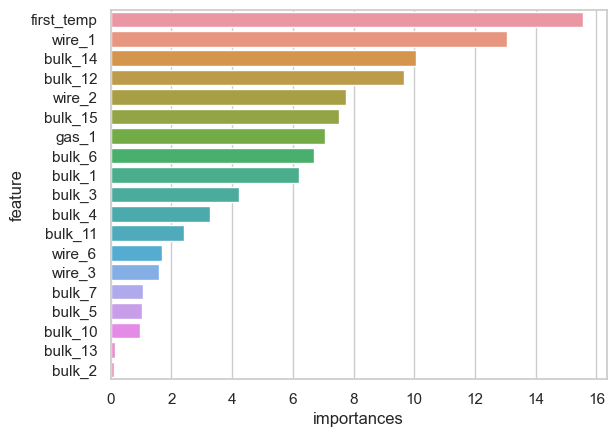

In [673]:
importance_plot(model_cat)

In [677]:
model_cat_impr = CatBoostRegressor(iterations=500,
                                   loss_function='MAE',
                                   random_seed=rng_state,
                                   learning_rate=0.05,
                                   train_dir="cat_metric",
                                   logging_level="Silent"
                                   )

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model_cat_impr.grid_search(grid,
                                                X=features_train,
                                                y=target_train,
                                                plot=False
                                                )

0:	loss: 8.9802181	best: 8.9802181 (0)	total: 1.72s	remaining: 50s
1:	loss: 9.1816512	best: 8.9802181 (0)	total: 3.58s	remaining: 50.2s
2:	loss: 9.0075496	best: 8.9802181 (0)	total: 5s	remaining: 45s
3:	loss: 9.1958986	best: 8.9802181 (0)	total: 6.06s	remaining: 39.4s
4:	loss: 9.1485992	best: 8.9802181 (0)	total: 7.23s	remaining: 36.1s
5:	loss: 9.2202747	best: 8.9802181 (0)	total: 8.12s	remaining: 32.5s
6:	loss: 9.1540477	best: 8.9802181 (0)	total: 9.06s	remaining: 29.8s
7:	loss: 9.2489841	best: 8.9802181 (0)	total: 10s	remaining: 27.5s
8:	loss: 9.0950387	best: 8.9802181 (0)	total: 10.8s	remaining: 25.3s
9:	loss: 9.2990248	best: 8.9802181 (0)	total: 11.8s	remaining: 23.6s
10:	loss: 13.7390738	best: 8.9802181 (0)	total: 13.2s	remaining: 22.8s
11:	loss: 14.2641758	best: 8.9802181 (0)	total: 15.2s	remaining: 22.8s
12:	loss: 13.6983156	best: 8.9802181 (0)	total: 16.6s	remaining: 21.7s
13:	loss: 14.2000129	best: 8.9802181 (0)	total: 18.3s	remaining: 20.9s
14:	loss: 13.7071880	best: 8.980218

In [678]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [679]:
def selecting_catboost_gbm(features_final, target_final):
    models_final = CatBoostRegressor(iterations=500,
                                     loss_function='MAE',
                                     random_seed=rng_state,
                                     train_dir="cat_metric",
                                     depth=4,
                                     l2_leaf_reg=1,
                                     learning_rate=0.03,
                                     logging_level="Silent")
    models_final.fit(features_final, target_final)
    return models_final

In [680]:
models_Cat = selecting_catboost_gbm(features_train, target_train)

In [681]:
metric_calc(models_Cat)

Дополнительные метрики  :: RMSE: 10.31, r_2: 0.19, MAE: 7.12
Итоговое MAE: 7.12
